<a href="https://colab.research.google.com/github/subod4/NLP/blob/main/Text_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy gradio
!python -m spacy download en_core_web_sm

In [ ]:
import gradio as gr
import spacy
from collections import Counter
from heapq import nlargest

def summarize_text(text, num_sentences):
    if not text.strip():
        return "Please enter some text to summarize."

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
    word_freq = Counter(tokens)

    if not word_freq:
        return "No meaningful words found in the text."

    max_freq = max(word_freq.values())
    for word in word_freq.keys():
        word_freq[word] = word_freq[word] / max_freq

    sent_token = [sent.text for sent in doc.sents]
    sent_score = {sent: sum(word_freq.get(word.lower(), 0) for word in sent.split()) for sent in sent_token}

    summarized_sentences = nlargest(num_sentences, sent_score, key=sent_score.get)
    return " ".join(summarized_sentences)

# Create Gradio UI
iface = gr.Interface(
    fn=summarize_text,
    inputs=[
        gr.Textbox(lines=10, placeholder="Enter text here..."),
        gr.Slider(minimum=1, maximum=10, value=3, label="Number of Sentences")
    ],
    outputs="text",
    title="AI Text Summarizer",
    description="Enter your text, select the number of sentences, and get a summarized version!"
)

# Launch the interface
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9c87377dee3b0b84db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Abstractive Summary

In [2]:
!pip install transformers datasets torch rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)

# Load dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_data = dataset["train"].shuffle(seed=42).select(range(10000))  # Use only 10K samples
val_data = dataset["validation"].shuffle(seed=42).select(range(2000))  # Use only 2K samples

# Load model & tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenization function with padding
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(
        inputs, max_length=512, truncation=True, padding="max_length"
    )

    labels = tokenizer(
        examples["highlights"], max_length=150, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize data
train_dataset = train_data.map(preprocess_function, batched=True)
val_dataset = val_data.map(preprocess_function, batched=True)

# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding="longest")

# Set training parameters
training_args = TrainingArguments(
    output_dir="./results1",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,  # Ensures consistent batching
)

# Train model
trainer.train()

model.save_pretrained("./results")
tokenizer.save_pretrained("./results")



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.036800,0.998474
2,0.992100,0.993374
3,0.983100,0.993567


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/spiece.model',
 './results/added_tokens.json')

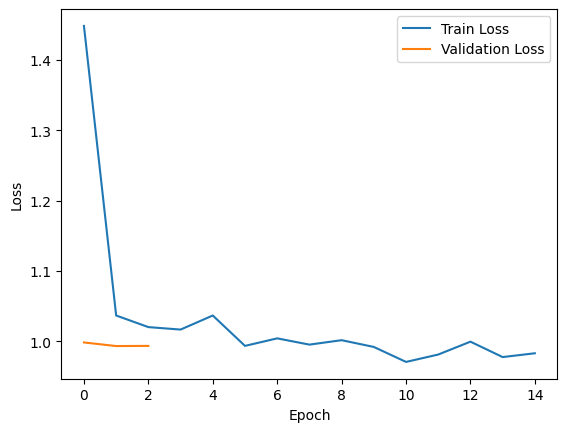

In [8]:
import matplotlib.pyplot as plt

history = trainer.state.log_history
train_loss = [entry["loss"] for entry in history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in history if "eval_loss" in entry]

plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training_loss_curve.png")  # Save the image
plt.show()


In [ ]:
import torch
from rouge_score import rouge_scorer

# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

def evaluate_model(model, dataset):
    total_scores = {"rouge1": 0, "rouge2": 0, "rougeL": 0}
    num_samples = len(dataset)

    for i in range(num_samples):  # Iterate correctly through dataset
        sample = dataset[i]

        # Tokenize input & move to device
        inputs = tokenizer("summarize: " + sample["article"], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to GPU

        # Generate summary
        with torch.no_grad():  # Disable gradient calculation for inference
            summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)

        generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        # Compute ROUGE score
        scores = scorer.score(sample["highlights"], generated_summary)
        for key in total_scores:
            total_scores[key] += scores[key].fmeasure

    # Compute average scores
    for key in total_scores:
        total_scores[key] /= num_samples

    return total_scores

# Evaluate model
rouge_scores = evaluate_model(model, val_data)
print("ROUGE Scores:", rouge_scores)


In [2]:
!pip install gradio

In [10]:
import gradio as gr
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the fine-tuned model
model_path = "./results"  # Use the correct model path
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the Summarization Function
def summarize_text(text):
    if not text.strip():
        return "Please enter some text to summarize."

    inputs = tokenizer("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,
        min_length=10,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Create Gradio Interface
interface = gr.Interface(
    fn=summarize_text,
    inputs=gr.Textbox(label="Input Text", lines=10, placeholder="Enter your text here..."),
    outputs=gr.Textbox(label="Summary", lines=5),
    title="Fine-Tuned T5 Summarizer",
    description="This summarizer uses a custom fine-tuned T5 model.",
)

# Launch the Gradio App
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://356bc1994475a3f43b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
